In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Find the most recent training run
log_dir = Path("/tmp/character-training")
runs = sorted(log_dir.glob("qwen-3-4b-it-sarcasm-*"))
LOG_PATH = runs[-1] if runs else None
print(f"Using: {LOG_PATH}")

Using: /tmp/character-training/qwen-3-4b-it-sarcasm-2025-11-30-22-37


In [20]:
# Read metrics
metrics = pd.read_json(f"{LOG_PATH}/metrics.jsonl", lines=True)
print(f"Steps so far: {len(metrics)}")
print(f"Columns: {list(metrics.columns)}")

Steps so far: 49
Columns: ['step', 'epoch', 'time/evals', 'time/infrequent_evals', 'time/get_batch', 'time/get_ref_logprobs', 'time/step', 'num_pairs', 'num_tokens', 'learning_rate', 'progress', 'clock_cycle:unique', 'loss:sum', 'dpo_loss', 'accuracy', 'margin', 'chosen_reward', 'rejected_reward', 'nll_loss', 'total_loss', 'time/total', 'time/save_checkpoint', 'state_path']


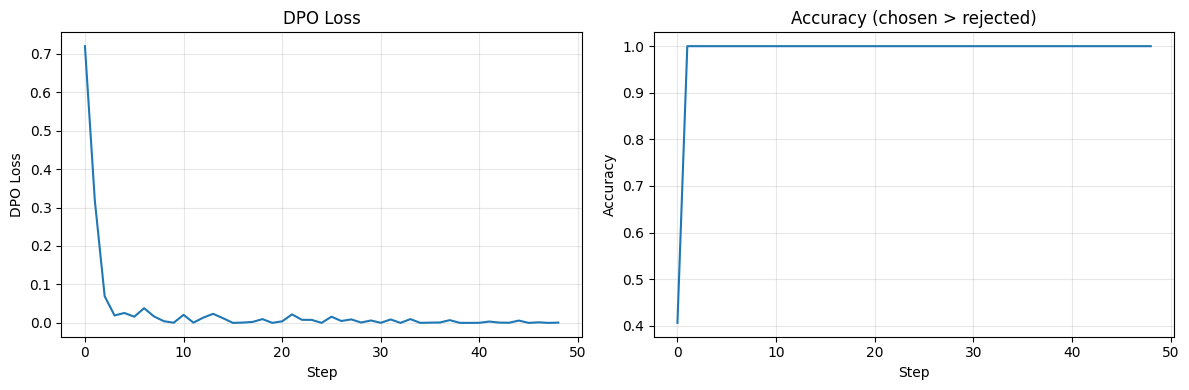

In [21]:
# Plot DPO loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(metrics['dpo_loss'])
axes[0].set_xlabel('Step')
axes[0].set_ylabel('DPO Loss')
axes[0].set_title('DPO Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(metrics['accuracy'])
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy (chosen > rejected)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

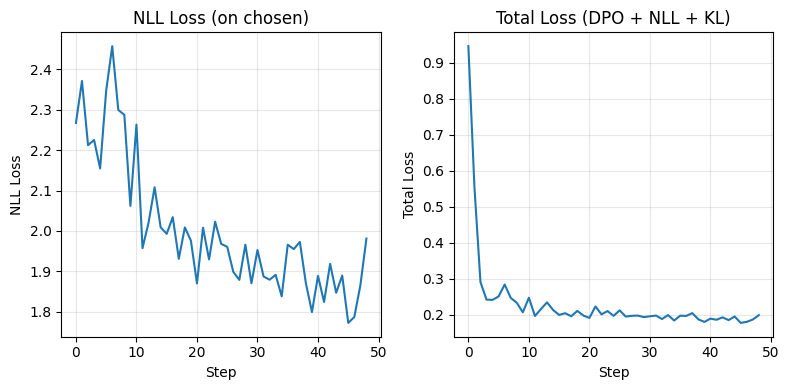

In [22]:
# Plot NLL and KL loss if present
has_nll = 'nll_loss' in metrics.columns and metrics['nll_loss'].notna().any()
has_kl = 'kl_loss' in metrics.columns and metrics['kl_loss'].notna().any()

if has_nll or has_kl:
    num_plots = sum([has_nll, has_kl, True])  # +1 for total_loss
    fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))
    if num_plots == 1:
        axes = [axes]
    
    idx = 0
    if has_nll:
        axes[idx].plot(metrics['nll_loss'])
        axes[idx].set_xlabel('Step')
        axes[idx].set_ylabel('NLL Loss')
        axes[idx].set_title('NLL Loss (on chosen)')
        axes[idx].grid(True, alpha=0.3)
        idx += 1
    
    if has_kl:
        axes[idx].plot(metrics['kl_loss'])
        axes[idx].set_xlabel('Step')
        axes[idx].set_ylabel('KL Loss')
        axes[idx].set_title('KL Divergence (π || π_ref)')
        axes[idx].grid(True, alpha=0.3)
        idx += 1
    
    axes[idx].plot(metrics['total_loss'])
    axes[idx].set_xlabel('Step')
    axes[idx].set_ylabel('Total Loss')
    axes[idx].set_title('Total Loss (DPO + NLL + KL)')
    axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No NLL or KL loss in metrics (nll_loss_coef=0 and kl_loss_coef=0?)")

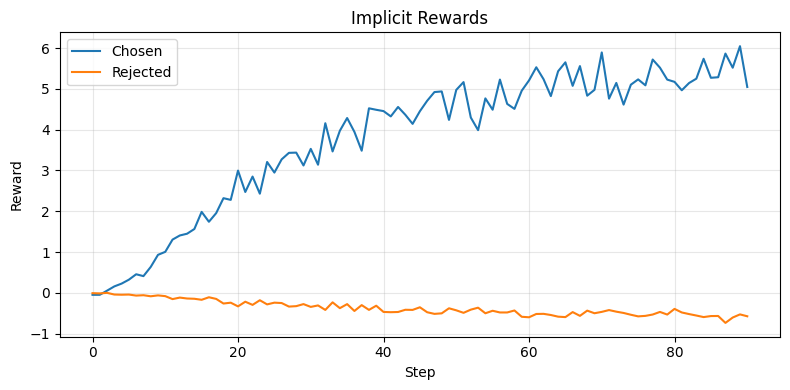

In [14]:
# Plot rewards
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(metrics['chosen_reward'], label='Chosen')
ax.plot(metrics['rejected_reward'], label='Rejected')
ax.set_xlabel('Step')
ax.set_ylabel('Reward')
ax.set_title('Implicit Rewards')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Summary stats
print("=== Training Summary ===")
print(f"Steps completed: {len(metrics)}")
print(f"Progress: {metrics['progress'].iloc[-1]*100:.1f}%")
print(f"\nFinal DPO Loss: {metrics['dpo_loss'].iloc[-1]:.4f}")
print(f"Final Accuracy: {metrics['accuracy'].iloc[-1]:.4f}")
print(f"Final Margin: {metrics['margin'].iloc[-1]:.4f}")
if 'nll_loss' in metrics.columns and metrics['nll_loss'].notna().any():
    print(f"Final NLL Loss: {metrics['nll_loss'].iloc[-1]:.4f}")
if 'kl_loss' in metrics.columns and metrics['kl_loss'].notna().any():
    print(f"Final KL Loss: {metrics['kl_loss'].iloc[-1]:.4f}")
if 'total_loss' in metrics.columns:
    print(f"Final Total Loss: {metrics['total_loss'].iloc[-1]:.4f}")